In this notebook, all features are selected using random forest algorithm. Their importance levels are visualized using a bar plot. The selected features are feed into a random forest again to test out the performance.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
#from xgboost.sklearn import XGBClassifier

np.random.seed(0)

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import sklearn
import sklearn.grid_search
#from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

import math

from NDCG_score_func import ndcg_scorer

### Loading data

In [2]:
X= np.load('X.npy')
y= np.load('y.npy')
X_test= np.load('X_test.npy')

df_all = pd.read_csv('df_all.csv')
df_all.set_index('id',inplace=True)

### Feature seletion by Random Forest

Using the paramters tunned in the notebook 'Classifier_RF', random forest is used to seltect features as shown below. All samples in the training set are used.

In [3]:
#Cross validation for one fixed parameter set
clf = RandomForestClassifier(max_features=40, n_estimators=120, n_jobs=1, min_samples_split=5)#n_jobs=2 #, min_samples_split=5  max_features=12
#view the whole data set as trainning set, and cross validate using K-fold cross validata(K=10)
clf.fit(X,y)
importance_list = clf.feature_importances_
name_list = df_all.columns

Showing the level of feature importance.

In [4]:
#zip the lists-sort the result-uppack using zip(*sorted(zip(
#see http://stackoverflow.com/questions/2732994/python-sort-a-list-and-change-another-one-consequently
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))

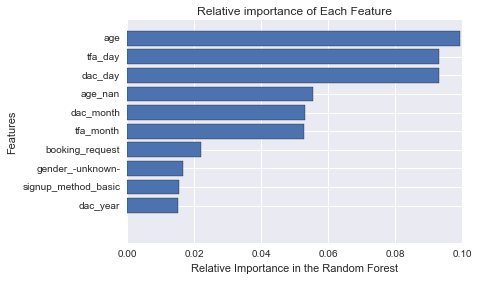

In [5]:
importance_list_1=importance_list[-10:]
name_list_1=name_list[-10:]

plt.barh(range(len(name_list_1)),importance_list_1,align='center')
#set the location and lables of y-axis point values
plt.yticks(range(len(name_list_1)),name_list_1)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

From above, it can be seen that the most important features are age, and date-time features, the indicator for missingness of 'gender'.

In [6]:
len(importance_list)

226

There are a total of 226 features.

In [12]:
sum(list(importance_list)[-100:])

0.97314668728234255

The most important 100 features renders 97.3% gain in random forest. Therefore, let's try to see the performance using k-fold cross validation with these 100 most important features.

In [13]:
importance_list_1=importance_list[-100:]
name_list_1=name_list[-100:]
df_all_slt=df_all[list(name_list_1)]

In [14]:
df_all_slt.head()

,language_zh,language_fr,listing_reviews,partner_callback,signup_flow_25.0,campaigns,reviews,signup_app_Moweb,first_affiliate_tracked_product,first_device_type_Desktop (Other),...,dac_year,signup_method_basic,gender_-unknown-,booking_request,tfa_month,dac_month,age_nan,dac_day,tfa_day,age
id,,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,0,0,-0.983523,-0.984374,0,-0.980432,-0.989965,0,0,0,...,-1.0,0,1,-0.960434,-0.636364,-0.090909,1,0.800000,0.200000,0.031327
820tgsjxq7,0,0,-0.983523,-0.984374,0,-0.980432,-0.989965,0,0,0,...,-0.5,0,0,-0.960434,-0.272727,-0.272727,0,0.600000,0.466667,0.204489
4ft3gnwmtx,0,0,-0.983523,-0.984374,0,-0.980432,-0.989965,0,0,0,...,-1.0,1,0,-0.960434,-0.090909,0.454545,0,0.800000,-0.466667,2.275654
bjjt8pjhuk,0,0,-0.983523,-0.984374,0,-0.980432,-0.989965,0,0,0,...,-0.5,0,0,-0.960434,0.636364,1.000000,0,-0.733333,1.000000,0.664748
87mebub9p4,0,0,-0.983523,-0.984374,0,-0.980432,-0.989965,0,0,0,...,-1.0,1,1,-0.960434,1.000000,0.454545,0,-0.133333,-0.533333,0.549683


### K-fold cross-validation to estimate the test performance.

Data preparation:

In [63]:
df_train = pd.read_csv('train_users_2.csv')
df_test = pd.read_csv('test_users.csv')
labels = df_train['country_destination'].values
df_train = df_train.drop(['country_destination'], axis=1)
piv_train = df_train.shape[0]  #

In [64]:
#dataFrame to numpy arrays
vals = df_all_slt.values

#training set
X = vals[:piv_train]
#transform labels into integers
le = LabelEncoder()
y = le.fit_transform(labels) #is this  integer encoding a must-do or optional?

#shuffling
y = y.reshape((len(y),1))
Xy = np.concatenate((X,y),axis = 1)
np.random.shuffle(Xy)
X = Xy[:,:(X.shape[1])]
y = Xy[:,X.shape[1]]

#test set
X_test = vals[piv_train:]

__Random forest classifier__

In [53]:
%%time
clf = RandomForestClassifier(max_features=20, n_estimators=120, n_jobs=1, min_samples_split=5)#n_jobs=2 #, min_samples_split=5  max_features=12
#view the whole data set as trainning set, and cross validate using K-fold cross validata(K=10)
kf = KFold(len(X), n_folds=5, random_state=42)
score_list = cross_val_score(clf, X, y, cv=kf,scoring=ndcg_scorer)# scoring=ndcg_scorer
print score_list
print 'The avaerage NDCG score is %d'%np.mean(score_list)

[ 0.81922481  0.81851496  0.81835913  0.82109736  0.81960686]
0.819360624246
Wall time: 12min 38s


The avaerage NDCG score is 81.9%.

### Generating Submission to Kaggle competetion

In [65]:
# #set up classifier parameters
# #number of n_estimators trees 
# clf = RandomForestClassifier(n_estimators = 120,max_features = 20, min_samples_split=5, n_jobs=1)
# clf.fit(X,y)
# y_pred = clf.predict_proba(X_test)

# #Taking the 5 classes with highest probabilities
# ids = []  #list of ids
# cts = []  #list of countries
# for i in range(len(id_test)):
#     #idx:internal variable 
#     idx = id_test[i] 
#     #dupliccate ids 5 times and put it to the list ids
#     ids += [idx] * 5
#     cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()
    
# #Generate submission
# sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
# sub.to_csv('sub4.csv',index=False)
# sub.head()

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,IT
4,5uwns89zht,ES
